In [21]:
import pickle as pickle

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.preprocessing as preprocessing
import sklearn.neural_network as nn
import sklearn.svm as svm
import sklearn.metrics as metrics

In [2]:
def load_dataset(n):
    data = pd.read_csv(f'Datasets/Duplicated{n}MeanPastMatches.csv')
    diff_data = pd.DataFrame()
    # Calculate diffs
    cols = ("age", "ht", "ace", "df", "svpt", "1stIn", "1stWon", "2ndWon", "SvGms", "bpSaved", "bpFaced", "rank")
    for col in cols:
        diff_data[f'{n}_diff_{col}'] = data['player1_' + col] - data['player2_' + col]

    # scaler = preprocessing.StandardScaler()
    # new_dataset[diff_cols] = scaler.fit_transform(new_dataset[diff_cols])
    # new_dataset['date'] = data['tourney_date']

    return diff_data


In [3]:
ns = range(1, 16)
datasets = []
for n in ns:
    datasets.append(load_dataset(n))

data = pd.concat(datasets, axis=1)
quant_cols = data.columns

In [4]:
first_dataset = pd.read_csv('Datasets/Duplicated1MeanPastMatches.csv')
data['date'] = first_dataset['tourney_date']

ohc = preprocessing.OneHotEncoder()
surfaces = ohc.fit_transform(first_dataset['surface'].values.reshape((-1, 1))).toarray()
surface_df = pd.DataFrame(surfaces, columns=['surface' + '_' + str(i) for i in range(surfaces.shape[1])])
data = pd.concat([data, surface_df], axis=1)
data['same_hand'] = (first_dataset['player1_hand'] == first_dataset['player2_hand']).astype(int)
data['label'] = first_dataset['label']

scaler = preprocessing.StandardScaler()
data[quant_cols] = scaler.fit_transform(data[quant_cols])
data = data.dropna()

In [5]:
data.shape

(124234, 188)

In [6]:
data.head()

,1_diff_age,1_diff_ht,1_diff_ace,1_diff_df,1_diff_svpt,1_diff_1stIn,1_diff_1stWon,1_diff_2ndWon,1_diff_SvGms,1_diff_bpSaved,...,15_diff_bpFaced,15_diff_rank,date,surface_0,surface_1,surface_2,surface_3,surface_4,same_hand,label
0,-1.741835,0.848702,-0.284760,-2.172831,0.922253,0.807744,0.514128,1.768476,0.599856,0.000000,...,-0.227963,-0.381445,20000110,0.0,0.0,0.0,1.0,0.0,0,0
1,0.037060,0.742614,0.000000,-0.310404,0.642782,1.275385,1.256757,0.663178,0.599856,0.462396,...,-0.984223,1.438582,20000110,0.0,0.0,0.0,1.0,0.0,0,0
2,-0.963568,0.212175,0.000000,-0.310404,0.922253,0.510154,0.914005,0.773708,0.599856,0.924792,...,-1.267497,-0.197128,20000110,0.0,0.0,0.0,1.0,0.0,1,0
3,0.277952,-0.212175,-0.569520,-0.310404,-1.648877,-1.317898,-1.485258,-1.657946,-1.399664,0.000000,...,0.783816,-0.231016,20000110,0.0,0.0,0.0,1.0,0.0,1,0
4,0.667086,-0.530439,-2.420459,0.931213,-1.592982,-1.487950,-1.828010,-1.215827,-1.199712,-0.462396,...,1.829910,0.756278,20000110,0.0,0.0,0.0,1.0,0.0,1,0


In [7]:
# Split datasets
data_train = data[data['date'] < 20150101].drop('date', axis=1)
data_val = data[(data['date'] >= 20150101) & (data['date'] < 20190101)].drop('date', axis=1)
data_test = data[data['date'] >= 20190101].drop('date', axis=1)

In [8]:
X_train = data_train.drop('label', axis=1)
y_train = data_train['label']

X_val = data_val.drop('label', axis=1)
y_val = data_val['label']

X_test = data_test.drop('label', axis=1)
y_test = data_test['label']

In [9]:
# Train model
model = svm.SVC(verbose=True)
model.fit(X_train, y_train)

[LibSVM].......................................................*..............*
optimization finished, #iter = 69737
obj = -56514.808427, rho = -0.000014
nSV = 61184, nBSV = 56840
Total nSV = 61184


SVC(verbose=True)

In [10]:
import pickle

with open('svm_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [11]:
# Evaluate model
y_pred = model.predict(X_val)
(y_pred == y_val).mean()

np.float64(0.6409367681498829)

In [14]:
print(metrics.classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.64      0.64     10675
           1       0.64      0.64      0.64     10675

    accuracy                           0.64     21350
   macro avg       0.64      0.64      0.64     21350
weighted avg       0.64      0.64      0.64     21350



In [16]:
conf_matrix = metrics.confusion_matrix(y_val, y_pred)
print(conf_matrix)

[[6842 3833]
 [3833 6842]]


In [35]:
def show_matrix(matrix, title):
    plt.figure(figsize=(10, 7))
    sns.heatmap(matrix, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()


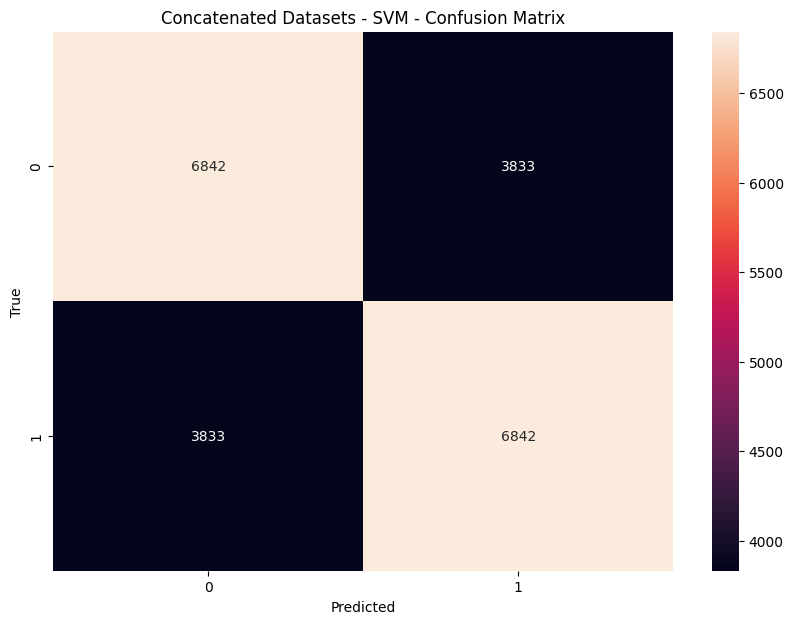

In [36]:
show_matrix(conf_matrix, 'Concatenated Datasets - SVM - Confusion Matrix')

In [31]:
mlp = nn.MLPClassifier(hidden_layer_sizes=(186, 93, 47, 24, 12, 6), verbose=True, max_iter=1000, early_stopping=True, n_iter_no_change=10)
mlp.fit(X_train, y_train)

Iteration 1, loss = 0.62981533
Validation score: 0.666293
Iteration 2, loss = 0.61943091
Validation score: 0.668285
Iteration 3, loss = 0.61661799
Validation score: 0.668783
Iteration 4, loss = 0.61415658
Validation score: 0.671397
Iteration 5, loss = 0.61172794
Validation score: 0.670525
Iteration 6, loss = 0.61105944
Validation score: 0.670525
Iteration 7, loss = 0.60895244
Validation score: 0.665297
Iteration 8, loss = 0.60789974
Validation score: 0.668658
Iteration 9, loss = 0.60529211
Validation score: 0.671397
Iteration 10, loss = 0.60353192
Validation score: 0.670027
Iteration 11, loss = 0.60161815
Validation score: 0.667289
Iteration 12, loss = 0.59970622
Validation score: 0.666044
Iteration 13, loss = 0.59748841
Validation score: 0.664426
Iteration 14, loss = 0.59487409
Validation score: 0.669032
Iteration 15, loss = 0.59129108
Validation score: 0.667165
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPClassifier(early_stopping=True, hidden_layer_sizes=(186, 93, 47, 24, 12, 6),
              max_iter=1000, verbose=True)

In [34]:
with open("./mlp_model.pkl", "wb") as f:
    pickle.dump(mlp, f)

In [32]:
y_pred_mlp = mlp.predict(X_val)

In [33]:
(y_pred_mlp == y_val).mean()

np.float64(0.6510070257611241)

In [37]:
print(metrics.classification_report(y_val, y_pred_mlp))

              precision    recall  f1-score   support

           0       0.65      0.66      0.66     10675
           1       0.65      0.64      0.65     10675

    accuracy                           0.65     21350
   macro avg       0.65      0.65      0.65     21350
weighted avg       0.65      0.65      0.65     21350



In [38]:
conf_matrix_mlp = metrics.confusion_matrix(y_val, y_pred_mlp)

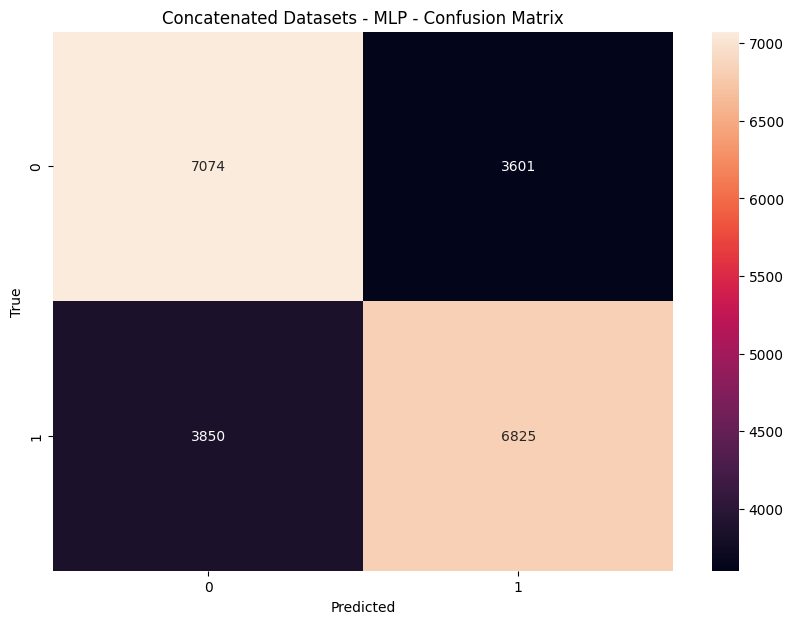

In [39]:
show_matrix(conf_matrix_mlp, 'Concatenated Datasets - MLP - Confusion Matrix')